In [4]:
import json
file_system = "/kaggle/input/mini-coco2014-dataset-for-image-captioning/captions.json"
print(len(file_system))
print(file_system[0])
with open(file_system,'r') as f:
    data = json.load(f)
print(data[0])
print(data[1])

70
/
{'image_id': 299675, 'id': 328, 'caption': 'A white square kitchen with tile floor that needs repairs '}
{'image_id': 513461, 'id': 572, 'caption': 'A surfer, a woman, and a child walk on the beach.'}


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict
import os
import json
from PIL import Image
import numpy as np
from transformers import BertTokenizer
# Custom Dataset Class
class CocoDataset(Dataset):
    def __init__(self, image_dir, caption_file, transform=None, max_length=30):
        self.image_dir = image_dir
        self.transform = transform
        self.captions = defaultdict(list)
        self.max_length = max_length
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.captions = defaultdict(list)
        # Load captions and build vocabulary
        with open(caption_file, 'r') as f:
            data = json.load(f)
            for d in data:
                img_id = d['image_id']
                caption = d['caption']
                tokens = self.tokenizer.encode(
                    caption,
                    add_special_tokens = True,
                    max_length = self.max_length,
                    truncation = True
                )
                self.captions[img_id].append(tokens)
        self.image_ids = list(self.captions.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        
        # Format img_id into the expected filename (e.g., COCO_train2014_000000000061.jpg)
        img_filename = f"COCO_train2014_{img_id:012d}.jpg"
        
        # Load the image
        image = Image.open(os.path.join(self.image_dir, img_filename)).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        # Get a random caption for the image
        captions = self.captions[img_id]
        caption = captions[np.random.randint(len(captions))]
        caption_tensor = torch.tensor(caption)
        
        return image, caption_tensor

# Collate Function
def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images)
    captions = pad_sequence(captions, padding_value=0, batch_first=True)
    return images, captions

# Create DataLoader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = CocoDataset(image_dir='/kaggle/input/mini-coco2014-dataset-for-image-captioning/Images', 
                     caption_file='/kaggle/input/mini-coco2014-dataset-for-image-captioning/captions.json',
                     transform=transform)
dataloader = DataLoader(dataset, batch_size=128, collate_fn=collate_fn, shuffle=True)
print(dataset.image_dir)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/kaggle/input/mini-coco2014-dataset-for-image-captioning/Images


In [8]:
import torch.nn as nn
from einops import rearrange

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, 
                             kernel_size=patch_size, stride=patch_size)
        num_patches = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

    def forward(self, x):
        x = self.proj(x)  # (B, E, H/P, W/P)
        x = rearrange(x, 'b e h w -> b (h w) e')
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embed
        return x

class ViTEncoder(nn.Module):
    def __init__(self, embed_dim=768, num_layers=6, num_heads=12):
        super().__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

    def forward(self, x):
        return self.encoder(x)

In [10]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=768, num_layers=6, num_heads=12):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, 100, embed_dim))
        self.decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(embed_dim, vocab_size)

    def forward(self, trg, memory, trg_mask=None):
        trg_embedded = self.embed(trg) + self.pos_embed[:, :trg.shape[1], :]
        output = self.decoder(trg_embedded, memory, tgt_mask=trg_mask)
        return self.fc_out(output)


In [11]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, patch_embed, encoder, decoder):
        super().__init__()
        self.patch_embed = patch_embed
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions, caption_mask=None):
        # Process images through patch embedding
        embedded_patches = self.patch_embed(images)
        # Encode the patches
        memory = self.encoder(embedded_patches)
        # Decode with captions and memory
        outputs = self.decoder(captions, memory, caption_mask)
        return outputs

# Initialize model
embed_dim = 768
patch_embed = PatchEmbedding(img_size=224, patch_size=16, in_channels=3, embed_dim=embed_dim)
vocab_size = 30522
encoder = ViTEncoder(embed_dim=embed_dim)
decoder = TransformerDecoder(vocab_size, embed_dim=embed_dim)
model = ImageCaptioningModel(patch_embed, encoder, decoder)


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def create_mask(size):
    mask = torch.triu(torch.ones(size, size), diagonal=1).bool()
    return mask.to(device)
for epoch in range(5):
    model.train()
    for images, captions in dataloader:
        images = images.to(device)
        captions = captions.to(device)
        
        # Create target (shifted right) and mask
        trg_input = captions[:, :-1]
        trg_output = captions[:, 1:]
        trg_mask = create_mask(trg_input.size(1))
        optimizer.zero_grad()
        outputs = model(images, trg_input, trg_mask)
        loss = criterion(outputs.reshape(-1, outputs.shape[-1]), 
                        trg_output.reshape(-1))
        loss.backward()
        optimizer.step()
    
    print(f'Epoch: {epoch+1}, Loss: {loss.item()}')


cuda
Epoch: 1, Loss: 3.7308454513549805
Epoch: 2, Loss: 3.438864231109619
Epoch: 3, Loss: 3.3455209732055664
Epoch: 4, Loss: 3.2785465717315674
Epoch: 5, Loss: 3.2839395999908447


In [17]:
import torch
from PIL import Image
from transformers import BertTokenizer
from torchvision import transforms

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def generate_caption(image_path, model, tokenizer, transform, max_length=30):
    # Set the device (CPU or GPU)
    device = next(model.parameters()).device
    
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    
    model.eval()
    with torch.no_grad():
        # Encode the image using the ViT encoder
        embedded_patches = model.patch_embed(image)
        memory = model.encoder(embedded_patches)
        
        # Initialize the caption with the [CLS] token
        generated_ids = [tokenizer.cls_token_id]
        
        # Generate tokens step by step
        for _ in range(max_length):
            current_ids = torch.tensor(generated_ids).unsqueeze(0).to(device)
            current_length = current_ids.size(1)
            
            # Create a mask to prevent looking at future tokens
            trg_mask = torch.triu(torch.ones(current_length, current_length), diagonal=1).bool().to(device)
            
            # Decode the current tokens to get next token logits
            decoder_output = model.decoder(current_ids, memory, trg_mask)
            next_token_logits = decoder_output[:, -1, :]
            
            # Greedy decoding: select the token with the highest probability
            next_token = next_token_logits.argmax(-1).item()
            generated_ids.append(next_token)
            
            # Stop if [SEP] token is generated
            if next_token == tokenizer.sep_token_id:
                break
        
        # Decode the token IDs to a string, skipping special tokens
        caption = tokenizer.decode(generated_ids, skip_special_tokens=True)
    
    return caption

# Example usage
image_path = '/kaggle/input/coco-image-caption/val2017/val2017/000000002473.jpg'  # Replace with your image path
caption = generate_caption(image_path, model, tokenizer, transform)
print(f"Generated Caption: {caption}")


Generated Caption: a man in a snowboarding on a snow covered slope.


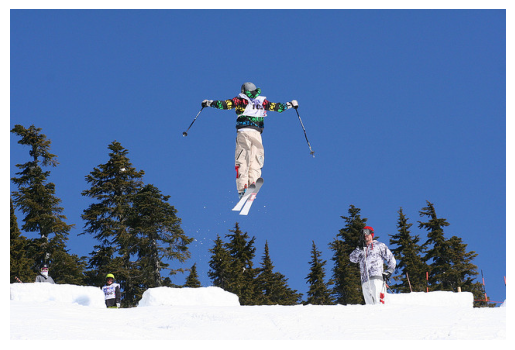

In [18]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image_path = '/kaggle/input/coco-image-caption/val2017/val2017/000000002473.jpg'
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()
